# Sprint 9 · Webinar 27 · Data Analytics teórico  
## Validar hipótesis de negocio con pruebas estadísticas

**Programa:** Data Analytics  
**Sprint:** 9  
**Duración:** 100 minutos  
**Modalidad:** Teórica (con demostraciones en Python)


## Fecha
**11 de febrero de 2026**


## Objetivos de la sesión

Al finalizar la sesión, el/la estudiante podrá:

1. Convertir **preguntas de negocio** en **preguntas medibles con datos** (métrica + comparación).
2. Explicar por qué usamos **pruebas de hipótesis**: *muestra vs. población* y *variabilidad*.
3. Validar si los datos están listos para “probar” una pregunta (calidad, tamaño, supuestos básicos).
4. Elegir una prueba según el tipo de variable:
   - comparar **promedios** → *t-test*  
   - comparar **proporciones** → *z-test de proporciones*  
   - relación entre **categóricas** → *chi-cuadrada (χ²)*
5. Ejecutar e **interpretar** el resultado de cada prueba con lenguaje de negocio.


## Agenda sugerida (100 minutos)

| Tiempo | Bloque | Contenido |
|---:|---|---|
| 0–10 | Actividad 0 | “De pregunta de negocio a pregunta medible” (sin estadística formal) |
| 10–25 | Dataset | Crear dataset extenso + exploración rápida |
| 25–45 | Fundamentos | Muestra vs población, variabilidad, error y p-value (conceptual) |
| 45–70 | Comparar grupos | t-test (promedios) y z-test (proporciones) |
| 70–92 | Categóricas | χ² + supuestos + visualización |
| 92–100 | Cierre | Takeaways y próximos pasos |


## Actividad 0 · Calentamiento (10 min)

Tus estudiantes aún no conocen hipótesis nula/alternativa, así que aquí solo buscamos **intuición de medición**.

En equipos (breakout rooms), respondan:

1. Piensen en un negocio digital (e-commerce, app, streaming, banco, etc.) y escriban **2 preguntas** del tipo:
   - “¿La versión B mejora algo frente a la A?”
   - “¿Este segmento se comporta diferente a este otro?”
2. Para **1 pregunta**, definan:
   - **Qué métrica** observarían (ej.: tasa de conversión, tiempo promedio, ticket promedio).
   - **Qué grupos** compararían (ej.: A vs B; Mobile vs Desktop; Región Andina vs Caribe).
3. ¿Por qué creen que los números **no salen exactamente iguales** aunque el producto sea “el mismo”?  
   (pista: usuarios diferentes, azar, contexto, tamaño de muestra)
4. ¿Qué información adicional pedirías antes de tomar una decisión?  
   (pista: tamaño de muestra, periodo, sesgos, eventos externos)

> Objetivo: entender que en datos reales siempre hay **variabilidad** y que necesitamos un método para decidir con evidencia.


In [2]:
# ============================================================
# Imports y configuración (ejecuta esta celda primero)
# ============================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

RANDOM_SEED = 42


## Ejercicio 1 · Crear un dataset extenso para practicar (15 min)

**Caso:** experimento A/B de checkout en e-commerce  
- Variante **A**: checkout actual  
- Variante **B**: checkout nuevo  

Variables incluidas (para practicar distintos tipos de pruebas):
- **Binaria (proporción):** `converted` (0/1)
- **Numérica (promedio):** `order_value_usd` (solo si convierte)
- **Categóricas:** `device`, `region`, `traffic_source`, `payment_method`, `variant`
- **Ordinal:** `satisfaction_1_5` (solo si convierte)

También incluimos de forma controlada:
- **Missing values** (para practicar validación de datos)
- **Outliers** en `order_value_usd` (para visualizar colas largas)


In [3]:
# ============================================================
# Generación del dataset sintético (controlado y reproducible)
# ============================================================

def generate_sprint9_dataset(n_rows: int = 12000, seed: int = 42) -> pd.DataFrame:
    """
    Genera un dataset sintético para practicar pruebas estadísticas básicas en un contexto de negocio.

    Diseñado para principiantes:
    - Tipos de variables variados: numéricas, binarias, categóricas y ordinales.
    - Un efecto realista: la variante B mejora un poco la conversión (para que el z-test "tenga algo que encontrar").
    - Incluye problemas comunes: missing values y outliers.

    Parámetros:
    - n_rows: número de filas (usuarios)
    - seed: semilla para reproducibilidad
    """

    rng = np.random.default_rng(seed)

    # --- Categóricas ---
    variant = rng.choice(["A", "B"], size=n_rows, p=[0.50, 0.50])
    region = rng.choice(["Andina", "Caribe", "Pacífica", "Orinoquía-Amazonía"], size=n_rows, p=[0.50, 0.18, 0.22, 0.10])
    device = rng.choice(["Mobile", "Desktop", "Tablet"], size=n_rows, p=[0.68, 0.28, 0.04])
    traffic_source = rng.choice(["Organic", "Paid", "Referral", "Email"], size=n_rows, p=[0.42, 0.36, 0.12, 0.10])
    payment_method = rng.choice(["Card", "PSE", "Cash", "Wallet"], size=n_rows, p=[0.60, 0.20, 0.10, 0.10])

    # --- Comportamiento ---
    days_since_signup = rng.integers(0, 365, size=n_rows)
    pages_viewed = np.clip(rng.poisson(lam=6, size=n_rows), 1, 60)

    base_time = 1.2 + 0.35 * pages_viewed + rng.normal(0, 2.0, size=n_rows)
    device_time_adj = np.where(device == "Mobile", -1.0, np.where(device == "Tablet", 0.5, 0.0))
    time_on_site_min = np.clip(base_time + device_time_adj, 0.2, None)

    # --- Conversión (binaria) ---
    # Probabilidad base
    p = np.full(n_rows, 0.085)

    # Ajustes simples por fuente y dispositivo
    p += np.where(traffic_source == "Email", 0.030, 0.0)
    p += np.where(traffic_source == "Paid", 0.010, 0.0)
    p += np.where(device == "Desktop", 0.015, 0.0)
    p += np.where(device == "Mobile", -0.005, 0.0)

    # Efecto de negocio a probar: B mejora conversión
    p += np.where(variant == "B", 0.012, 0.0)

    p = np.clip(p, 0.001, 0.90)
    converted = rng.binomial(n=1, p=p, size=n_rows)

    # --- Valor de orden (solo si convirtió) ---
    order_value = rng.lognormal(mean=3.45, sigma=0.55, size=n_rows)
    order_value *= np.where(payment_method == "Card", 1.05, 1.0)
    order_value *= np.where(region == "Andina", 1.03, 1.0)

    order_value_usd = np.where(converted == 1, order_value, np.nan)

    # --- Tickets de soporte y satisfacción (solo si convirtió) ---
    support_tickets_30d = np.clip(rng.poisson(lam=0.35, size=n_rows), 0, 10)

    satisfaction_latent = (
        3.6
        + np.where(variant == "B", 0.10, 0.0)
        - 0.35 * support_tickets_30d
        + rng.normal(0, 0.75, size=n_rows)
    )

    satisfaction_1_5 = np.clip(np.round(satisfaction_latent), 1, 5).astype(int)
    satisfaction_1_5 = np.where(converted == 1, satisfaction_1_5, np.nan)

    # --- Churn (binaria) ---
    churn_p = np.full(n_rows, 0.14)
    churn_p += np.where(converted == 0, 0.10, 0.0)
    churn_p += np.where(device == "Mobile", 0.02, 0.0)
    churn_p -= np.where((converted == 1) & (satisfaction_1_5 >= 4), 0.06, 0.0)

    churn_p = np.clip(churn_p, 0.01, 0.95)
    churned_30d = rng.binomial(n=1, p=churn_p, size=n_rows)

    df = pd.DataFrame({
        "user_id": np.arange(1, n_rows + 1),
        "variant": variant,
        "region": region,
        "device": device,
        "traffic_source": traffic_source,
        "payment_method": payment_method,
        "days_since_signup": days_since_signup,
        "pages_viewed": pages_viewed,
        "time_on_site_min": np.round(time_on_site_min, 2),
        "converted": converted,
        "order_value_usd": np.round(order_value_usd, 2),
        "support_tickets_30d": support_tickets_30d,
        "satisfaction_1_5": satisfaction_1_5,
        "churned_30d": churned_30d,
    })

    # --- Problemas controlados ---
    # Missing values
    miss_idx_time = rng.choice(df.index, size=int(0.01 * n_rows), replace=False)
    df.loc[miss_idx_time, "time_on_site_min"] = np.nan

    miss_idx_region = rng.choice(df.index, size=int(0.01 * n_rows), replace=False)
    df.loc[miss_idx_region, "region"] = np.nan

    # Outliers en order_value_usd (solo convertidos)
    conv_idx = df.index[df["converted"] == 1]
    if len(conv_idx) > 0:
        out_idx = rng.choice(conv_idx, size=max(1, int(0.003 * len(conv_idx))), replace=False)
        df.loc[out_idx, "order_value_usd"] *= 15

    return df

df = generate_sprint9_dataset(n_rows=12000, seed=RANDOM_SEED)
df.head()


,user_id,variant,region,device,traffic_source,payment_method,days_since_signup,pages_viewed,time_on_site_min,converted,order_value_usd,support_tickets_30d,satisfaction_1_5,churned_30d
0,1,B,Caribe,Desktop,Referral,PSE,0,6,3.24,0,NaN,1,NaN,0
1,2,A,Andina,Mobile,Organic,Card,302,5,0.20,0,NaN,1,NaN,0
2,3,B,Andina,Mobile,Paid,Card,42,9,10.10,0,NaN,0,NaN,1
3,4,B,Orinoquía-Amazonía,Mobile,Organic,PSE,267,8,0.20,0,NaN,0,NaN,1
4,5,A,Andina,Mobile,Organic,Wallet,6,8,1.59,0,NaN,0,NaN,0


In [4]:
# Exploración rápida

print("Dimensiones:", df.shape)


Dimensiones: (12000, 14)


In [5]:
display(df.sample(5, random_state=RANDOM_SEED))

,user_id,variant,region,device,traffic_source,payment_method,days_since_signup,pages_viewed,time_on_site_min,converted,order_value_usd,support_tickets_30d,satisfaction_1_5,churned_30d
1935,1936,A,Andina,Mobile,Paid,Wallet,152,7,6.61,1,70.8,0,4.0,0
6494,6495,B,Andina,Mobile,Paid,Card,167,6,3.76,0,NaN,0,NaN,0
1720,1721,A,Caribe,Mobile,Organic,Card,291,9,3.06,0,NaN,0,NaN,0
9120,9121,B,Andina,Mobile,Paid,Card,335,4,1.30,0,NaN,2,NaN,0
360,361,B,Andina,Mobile,Paid,Wallet,43,4,0.73,0,NaN,1,NaN,0


In [6]:
print("\nTipos de variables:")
display(df.dtypes)


Tipos de variables:


user_id                  int64
variant                 object
region                  object
device                  object
traffic_source          object
payment_method          object
days_since_signup        int64
pages_viewed             int64
time_on_site_min       float64
converted                int64
order_value_usd        float64
support_tickets_30d      int64
satisfaction_1_5       float64
churned_30d              int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              12000 non-null  int64  
 1   variant              12000 non-null  object 
 2   region               11880 non-null  object 
 3   device               12000 non-null  object 
 4   traffic_source       12000 non-null  object 
 5   payment_method       12000 non-null  object 
 6   days_since_signup    12000 non-null  int64  
 7   pages_viewed         12000 non-null  int64  
 8   time_on_site_min     11880 non-null  float64
 9   converted            12000 non-null  int64  
 10  order_value_usd      1228 non-null   float64
 11  support_tickets_30d  12000 non-null  int64  
 12  satisfaction_1_5     1228 non-null   float64
 13  churned_30d          12000 non-null  int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 1.3+ MB


In [8]:

print("\nPorcentaje de missing values por columna:")
display((df.isna().mean().sort_values(ascending=False) * 100).to_frame("missing_%").round(2))


Porcentaje de missing values por columna:


,missing_%
order_value_usd,89.77
satisfaction_1_5,89.77
region,1.00
time_on_site_min,1.00
variant,0.00
user_id,0.00
payment_method,0.00
traffic_source,0.00
device,0.00
days_since_signup,0.00


## 9.1 Formular preguntas de negocio como hipótesis (introducción gradual)

Antes de hablar de “hipótesis nula” y “alternativa”, necesitamos la idea base:

### ¿Qué significa “probar” una pregunta con datos?

1. El negocio hace un cambio (nuevo checkout, nueva campaña, nueva interfaz).
2. Medimos una métrica (conversión, ticket promedio, churn).
3. Observamos una diferencia entre dos grupos.

**Problema:**  
Aunque no haya un efecto real, por azar la muestra puede mostrar diferencias.

Por eso, una prueba estadística intenta responder:

> “Si el cambio NO tuviera efecto, ¿qué tan probable sería observar una diferencia como la que vimos?”

A esta lógica le agregamos un umbral (α) para decidir con una regla clara.


### 9.1.1 ¿Por qué necesitamos pruebas de hipótesis? (Muestra vs. Población)

- **Población:** todos los usuarios que nos interesan (hoy y en el futuro).  
- **Muestra:** los usuarios que observamos en el experimento / datos.

Como la muestra es limitada, trae **incertidumbre**.  
Dos muestras distintas podrían dar números distintos (variabilidad muestral).

**Pruebas de hipótesis**: una herramienta para decidir con evidencia, controlando el riesgo de equivocarnos.


### 9.1.2 Introducción al testing de hipótesis (ahora sí, vocabulario mínimo)

Cuando formalizamos la pregunta:

- **H0 (hipótesis nula):** “no hay efecto / no hay diferencia”.
- **H1 (hipótesis alternativa):** “sí hay efecto / sí hay diferencia”.

Además definimos:
- **α (alfa):** nivel de significancia (ej. 0.05). Controla el riesgo de **falso positivo** (Error Tipo I).
- **p-value:** mide qué tan compatible es lo observado con H0.
  - Si `p < α`: evidencia fuerte contra H0 → *rechazamos H0*.
  - Si `p ≥ α`: evidencia insuficiente contra H0 → *no rechazamos H0*.

> Importante: “no rechazar H0” NO significa “probar que no hay efecto”.


In [9]:
# Ejemplo: traducir una pregunta de negocio a H0/H1 (una sola vez)

business_question = "¿El checkout B aumenta la tasa de conversión frente a A?"
H0 = "La tasa de conversión es igual en A y B (p_A = p_B)."
H1 = "La tasa de conversión es mayor en B que en A (p_B > p_A)."

print("Pregunta de negocio:", business_question)
print("H0:", H0)
print("H1:", H1)


Pregunta de negocio: ¿El checkout B aumenta la tasa de conversión frente a A?
H0: La tasa de conversión es igual en A y B (p_A = p_B).
H1: La tasa de conversión es mayor en B que en A (p_B > p_A).


### 9.1.3 Validar si los datos están listos para probar una hipótesis

Antes de correr cualquier prueba, revisa:

1. **Definición de la métrica:** ¿cómo se calcula? ¿qué significa “converted=1”?
2. **Calidad de datos:** missing, duplicados, outliers, valores imposibles.
3. **Diseño del experimento:** ¿A/B fue aleatorio? ¿cada fila es un usuario independiente?
4. **Supuestos de la prueba:** algunos tests requieren tamaños mínimos o conteos esperados.

La estadística no arregla un mal dataset.


In [10]:
# Checklist básico de data readiness (sin funciones lambda)

# 1) Duplicados por user_id
dup_rate = df["user_id"].duplicated().mean()
print(f"Tasa de user_id duplicados: {dup_rate:.4f}")

Tasa de user_id duplicados: 0.0000


In [11]:
# 2) Missing values (conteo)
missing_counts = df.isna().sum().sort_values(ascending=False)
display(missing_counts.to_frame("missing_count").head(10))

,missing_count
order_value_usd,10772
satisfaction_1_5,10772
region,120
time_on_site_min,120
variant,0
user_id,0
payment_method,0
traffic_source,0
device,0
days_since_signup,0


In [12]:
# 3) Balance del experimento (chequeo simple)
#    Si el experimento fue aleatorio, variables de contexto deberían verse similares entre A y B.
#    (Esto no prueba aleatoriedad perfecta, pero sirve como alerta temprana.)

balance_n = df.groupby("variant")["user_id"].count()
balance_pages = df.groupby("variant")["pages_viewed"].mean()
balance_time = df.groupby("variant")["time_on_site_min"].mean()

mobile_rate = df.assign(is_mobile = (df["device"] == "Mobile").astype(int)).groupby("variant")["is_mobile"].mean()
paid_rate = df.assign(is_paid = (df["traffic_source"] == "Paid").astype(int)).groupby("variant")["is_paid"].mean()

balance = pd.DataFrame({
    "n": balance_n,
    "mean_pages_viewed": balance_pages,
    "mean_time_on_site_min": balance_time,
    "mobile_rate": mobile_rate,
    "paid_rate": paid_rate
})


In [14]:
balance

,n,mean_pages_viewed,mean_time_on_site_min,mobile_rate,paid_rate
variant,,,,,
A,6010,5.962895,2.792847,0.676040,0.355408
B,5990,6.020868,2.782891,0.679633,0.360601


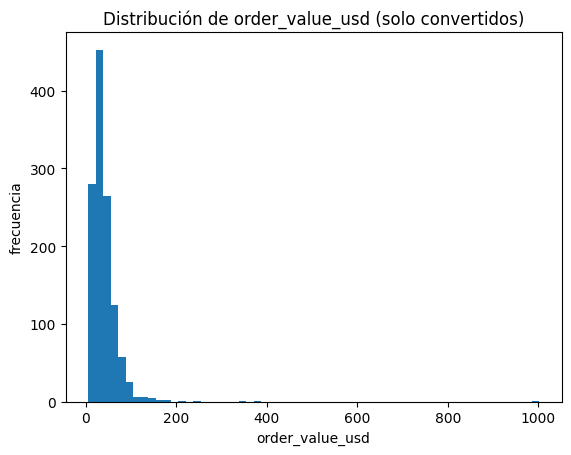

Resumen order_value_usd (convertidos):


count    1228.000000
mean       40.121979
std        38.931063
min         4.990000
50%        33.515000
90%        68.579000
95%        82.207000
99%       140.341600
max      1002.150000
Name: order_value_usd, dtype: float64

In [13]:
# 4) Visual simple para ver cola y outliers en order_value_usd
orders = df.loc[df["converted"] == 1, "order_value_usd"].dropna()

plt.figure()
plt.hist(orders, bins=60)
plt.title("Distribución de order_value_usd (solo convertidos)")
plt.xlabel("order_value_usd")
plt.ylabel("frecuencia")
plt.show()

print("Resumen order_value_usd (convertidos):")
display(orders.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


### 9.1.4 Cómo elegir la prueba estadística correcta

Piensa en **tipo de variable** y **pregunta**:

1. **¿Comparo promedios?** (variable numérica)  
   - Ej.: ticket promedio (`order_value_usd`) en A vs B  
   → **t-test**

2. **¿Comparo proporciones?** (variable binaria)  
   - Ej.: tasa de conversión (`converted`) en A vs B  
   → **z-test de proporciones**

3. **¿Busco relación entre dos categóricas?**  
   - Ej.: `device` vs `converted` (convertido sí/no)  
   → **Chi-cuadrada (χ²)**

> Regla mental: promedio/proporción/tabla de contingencia → t / z / χ²


## 9.2 Comparando promedios y proporciones con Python


### 9.2.1 Prueba t para comparar promedios (t-test)

**Idea:** compara el promedio de una variable numérica entre dos grupos.

Ejemplo:
> “Entre quienes compran, ¿el ticket promedio es distinto en A vs B?”

Notas importantes (para principiantes):
- Trabajaremos con `order_value_usd` **solo en convertidos**, porque los no convertidos tienen NaN.
- Como la distribución suele tener cola larga, el tamaño de muestra ayuda a que el promedio sea estable.
- Si las varianzas son diferentes, usamos una versión llamada **Welch**.


In [15]:
# Preparar datos para t-test: order_value_usd solo donde convirtió
df_orders = df.loc[df["converted"] == 1, ["variant", "order_value_usd"]].dropna()

In [ ]:
a = df_orders[df_orders["variant"] == "A"]["order_value_usd"]
b = df_orders[df_orders["variant"] == "B"]["order_value_usd"]

In [18]:
print("Tamaño de muestra (convertidos) A:", len(a))
print("Tamaño de muestra (convertidos) B:", len(b))

Tamaño de muestra (convertidos) A: 612
Tamaño de muestra (convertidos) B: 616


In [19]:
print("Promedio A:", round(a.mean(), 2))
print("Promedio B:", round(b.mean(), 2))

Promedio A: 39.2
Promedio B: 41.04


In [20]:
# Chequeo simple de varianzas: Levene
stat_levene, p_levene = stats.levene(a, b, center="median")

print(f"Levene p-value (varianzas iguales): {p_levene:.4f}")

Levene p-value (varianzas iguales): 0.3424


In [22]:
# Si p_levene es pequeño, preferimos Welch (equal_var=False).
equal_var = p_levene >= 0.05
equal_var

np.True_

In [23]:
t_stat, p_value = stats.ttest_ind(a, b, equal_var=True)
print(f"t-stat: {t_stat:.4f} | p-value: {p_value:.6f} | equal_var={equal_var}")

t-stat: -0.8294 | p-value: 0.407018 | equal_var=True


### 9.2.2 Interpretando los resultados de una prueba t

Además del p-value, reporta:

- **Diferencia de medias** (en unidades del negocio, aquí USD).
- Un **intervalo de confianza (IC)**: rango plausible de la diferencia real.

Si el IC incluye 0, normalmente la evidencia de diferencia es débil.


In [24]:
alpha = 0.05

mean_diff = b.mean() - a.mean()
print(f"Diferencia de medias (B - A): {mean_diff:.2f} USD")

# IC 95% aproximado para diferencia de medias (Welch)
se = np.sqrt(a.var(ddof=1)/len(a) + b.var(ddof=1)/len(b))
df_welch = (a.var(ddof=1)/len(a) + b.var(ddof=1)/len(b))**2 / (
    (a.var(ddof=1)/len(a))**2/(len(a)-1) + (b.var(ddof=1)/len(b))**2/(len(b)-1)
)
t_crit = stats.t.ppf(1 - alpha/2, df=df_welch)
ci_low, ci_high = mean_diff - t_crit*se, mean_diff + t_crit*se

print(f"IC 95% (aprox) para (B - A): [{ci_low:.2f}, {ci_high:.2f}] USD")

decision = "RECHAZAR H0" if p_value < alpha else "NO rechazar H0"
print(f"Decisión con α={alpha}: {decision}")


Diferencia de medias (B - A): 1.84 USD
IC 95% (aprox) para (B - A): [-2.51, 6.20] USD
Decisión con α=0.05: NO rechazar H0


### 9.2.3 Prueba z para comparar proporciones

**Idea:** comparar tasas entre dos grupos cuando el resultado es binario.

Ejemplo:
> “¿La tasa de conversión en B es mayor que en A?”

Para usar z-test necesitas tamaños razonables; con miles de usuarios suele funcionar bien.


In [25]:
df.head()

,user_id,variant,region,device,traffic_source,payment_method,days_since_signup,pages_viewed,time_on_site_min,converted,order_value_usd,support_tickets_30d,satisfaction_1_5,churned_30d
0,1,B,Caribe,Desktop,Referral,PSE,0,6,3.24,0,NaN,1,NaN,0
1,2,A,Andina,Mobile,Organic,Card,302,5,0.20,0,NaN,1,NaN,0
2,3,B,Andina,Mobile,Paid,Card,42,9,10.10,0,NaN,0,NaN,1
3,4,B,Orinoquía-Amazonía,Mobile,Organic,PSE,267,8,0.20,0,NaN,0,NaN,1
4,5,A,Andina,Mobile,Organic,Wallet,6,8,1.59,0,NaN,0,NaN,0


In [27]:
# Conteos de convertidos y total por variante
conv_stats = df.groupby("variant")["converted"].agg(["sum", "count"])
display(conv_stats)

# Importante: proportions_ztest espera arrays en el orden [A, B] o similar.
# Aquí asumimos que el orden alfabético es A luego B.
conv_stats = conv_stats.loc[["A", "B"]]

success = conv_stats["sum"].values
nobs = conv_stats["count"].values

rate_A = success[0] / nobs[0]
rate_B = success[1] / nobs[1]

print(f"Conversion rate A: {rate_A:.4%}")
print(f"Conversion rate B: {rate_B:.4%}")
print(f"Diferencia (B - A): {(rate_B - rate_A):.4%}")



,sum,count
variant,,
A,612,6010
B,616,5990


Conversion rate A: 10.1830%
Conversion rate B: 10.2838%
Diferencia (B - A): 0.1008%


In [28]:
success

array([612, 616])

In [29]:
nobs

array([6010, 5990])

In [30]:
# alternative="larger" significa H1: p_B > p_A
z_stat, p_z = proportions_ztest(count=success, nobs=nobs, alternative="larger")
print(f"z-stat: {z_stat:.4f} | p-value: {p_z:.6f}")

z-stat: -0.1821 | p-value: 0.572256


### 9.2.4 Interpretando los resultados de una prueba z

- Si `p < α`: evidencia de que la conversión en B es mayor que en A (según la dirección que definimos).
- Si `p ≥ α`: evidencia insuficiente.

En negocio, siempre comunica también el **tamaño** del cambio:
- “B sube conversión en +1.2 pp” (pp = puntos porcentuales)


In [31]:
alpha = 0.05
decision = "RECHAZAR H0 (evidencia de mejora en B)" if p_z < alpha else "NO rechazar H0 (evidencia insuficiente)"
print(f"Decisión con α={alpha}: {decision}")


Decisión con α=0.05: NO rechazar H0 (evidencia insuficiente)


## 9.3 Comprobando relaciones categóricas con Python


### 9.3.1 Prueba Chi-cuadrada (χ²) para variables categóricas

**Idea:** ver si dos variables categóricas están asociadas.

Ejemplo:
> “¿La conversión depende del dispositivo?”

Pasos:
1. Construir una **tabla de contingencia** (conteos).
2. Correr χ² para evaluar si las diferencias son mayores a lo esperable por azar.


In [ ]:
# Tabla de contingencia: device vs converted (0/1)
ct = pd.crosstab(df["device"], df["converted"])
display(ct)

chi2, p_chi, dof, expected = stats.chi2_contingency(ct)
print(f"chi2: {chi2:.4f} | dof: {dof} | p-value: {p_chi:.6f}")

expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
display(expected_df.round(2))


### 9.3.2 Supuestos y limitaciones de χ² (muy importante)

χ² funciona bien cuando:
- Las observaciones son independientes.
- Las categorías no tienen conteos minúsculos.
- Los **conteos esperados** en la tabla no son demasiado pequeños.

Regla práctica:
- idealmente, la mayoría de celdas esperadas ≥ 5.

Si hay categorías raras (muy pocas filas):
- agrupar categorías, o
- considerar pruebas alternativas (por ejemplo, Fisher en tablas 2x2).


In [ ]:
# Chequeo: cuántas celdas esperadas son < 5
expected_small = (expected < 5).sum()
total_cells = expected.size
print(f"Celdas con conteo esperado < 5: {expected_small}/{total_cells}")

# Ejemplo de agrupación simple: Tablet -> Desktop
df2 = df.copy()
df2["device_grouped"] = df2["device"].replace({"Tablet": "Desktop"})

ct2 = pd.crosstab(df2["device_grouped"], df2["converted"])
chi2_2, p_chi_2, dof_2, expected_2 = stats.chi2_contingency(ct2)

print("\nTabla agrupada (Tablet -> Desktop):")
display(ct2)
print(f"p-value (agrupada): {p_chi_2:.6f}")


### 9.3.3 Visualizar relaciones categóricas (para comunicar negocio)

A negocio le suele servir más ver **tasas** que ver solo conteos.

Ejemplo: tasa de conversión por dispositivo.


In [ ]:
# Tasa de conversión por dispositivo (sin lambdas)
conv_rate_by_device = df.groupby("device")["converted"].mean().sort_values(ascending=False)

plt.figure()
plt.bar(conv_rate_by_device.index, conv_rate_by_device.values)
plt.title("Tasa de conversión por dispositivo")
plt.xlabel("Dispositivo")
plt.ylabel("Conversion rate")
plt.ylim(0, conv_rate_by_device.max() * 1.25)
plt.show()

display(conv_rate_by_device.to_frame("conversion_rate"))


## Takeaways (8 min)

1. Primero: **pregunta de negocio → métrica + grupos**.  
2. Luego: aceptamos que hay **variabilidad** porque trabajamos con **muestras**, no con toda la población.
3. Las pruebas nos dan una regla para decidir: **p-value vs α** (controlando falsos positivos).
4. Elegir prueba depende de la variable:
   - promedio → t-test  
   - proporción → z-test  
   - relación categórica → χ²
5. En reportes reales, no basta con p-value: incluye **tamaño del efecto** y (si puedes) **intervalos de confianza**.


## Cierre y próximos pasos

Próximos temas típicos después de este Sprint:
- pruebas no paramétricas (Mann–Whitney),
- ANOVA (más de 2 grupos),
- intervalos de confianza para proporciones,
- corrección por múltiples pruebas (cuando haces muchas hipótesis).

**Pregunta final:**
Si B aumenta conversión pero baja ticket promedio, ¿qué KPI final prioriza el negocio y por qué?
